In [0]:
#  USE CASE 1 Historical Yield Trend Forecasting 
# Step 1: Load the data
df = spark.table("workspace.default.faostat_data_en_11_6_2025")
display(df.limit(10))

Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2019,2019,kg/ha,4083.6,A,Official figure,null
QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2020,2020,kg/ha,4075.7,A,Official figure,null
QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2021,2021,kg/ha,4196.2,A,Official figure,null
QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2022,2022,kg/ha,4257.1,A,Official figure,null
QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2023,2023,kg/ha,4322.3,A,Official figure,null


In [0]:
# Step 2: Convert to Pandas for analysis
import pandas as pd

df_pd = df.toPandas()
df_pd.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2019,2019,kg/ha,4083.6,A,Official figure,None
1,QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2020,2020,kg/ha,4075.7,A,Official figure,None
2,QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2021,2021,kg/ha,4196.2,A,Official figure,None
3,QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2022,2022,kg/ha,4257.1,A,Official figure,None
4,QCL,Crops and livestock products,356,India,5412,Yield,113,Rice,2023,2023,kg/ha,4322.3,A,Official figure,None


In [0]:
# Step 3: Data Cleaning
# Keep only relevant columns
df_clean = df_pd[['Area', 'Item', 'Year', 'Element', 'Value']]

# Filter only 'Yield' data
df_yield = df_clean[df_clean['Element'] == 'Yield']

# Drop missing values
df_yield = df_yield.dropna()

# Sort by year
df_yield = df_yield.sort_values(by='Year')
df_yield.head()


,Area,Item,Year,Element,Value
0,India,Rice,2019,Yield,4083.6
1,India,Rice,2020,Yield,4075.7
2,India,Rice,2021,Yield,4196.2
3,India,Rice,2022,Yield,4257.1
4,India,Rice,2023,Yield,4322.3


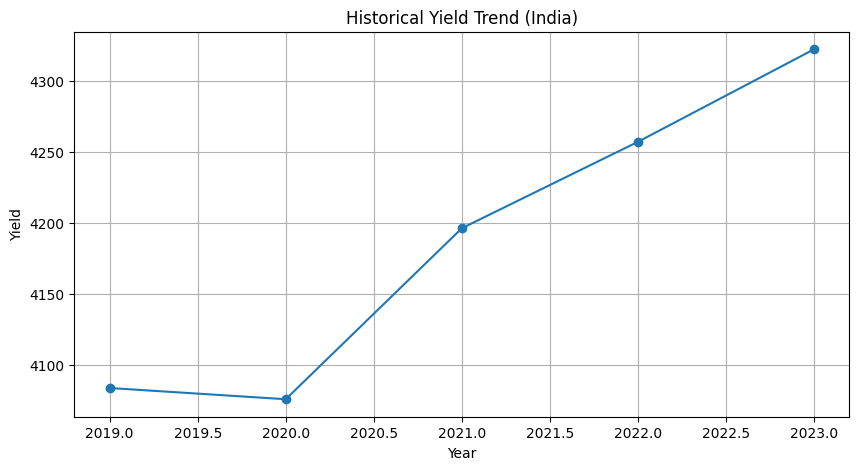

In [0]:
# Step 4: Visualize Yield Trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_yield['Year'], df_yield['Value'], marker='o')
plt.title("Historical Yield Trend (India)")
plt.xlabel("Year")
plt.ylabel("Yield")
plt.grid(True)
plt.show()

In [0]:
# Install Prophet (formerly fbprophet) and Plotly
%pip install prophet plotly


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Step 5: Time-Series Forecasting using Prophet
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df_yield[['Year', 'Value']].rename(columns={'Year': 'ds', 'Value': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Build model
model = Prophet()
model.fit(df_prophet)

# Forecast next 5 years
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)


import plotly.offline as py

# Convert Prophet's forecast plot into interactive Plotly figure
fig = plot_plotly(model, forecast)

# Display interactive Plotly chart (works inside Databricks, dashboard-compatible)
displayHTML(py.plot(fig, include_plotlyjs='cdn', output_type='div'))

# ✅ Step 1 — Show forecast DataFrame (dashboard visual option will appear here)
spark_forecast = spark.createDataFrame(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
display(spark_forecast)


13:50:11 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0237366a-850c-4d5a-bcbb-56203c5b8c9b/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



ds,yhat,yhat_lower,yhat_upper
2019-01-01T00:00:00.000Z,4083.599254502071,4083.5992544019823,4083.599254595231
2020-01-01T00:00:00.000Z,4075.699231312951,4075.699231217753,4075.6992314170707
2021-01-01T00:00:00.000Z,4196.199301159923,4196.199301065078,4196.199301267159
2022-01-01T00:00:00.000Z,4257.099277443368,4257.099277346224,4257.099277543533
2023-01-01T00:00:00.000Z,4322.299254164005,4322.299254069432,4322.299254258921
2023-12-31T00:00:00.000Z,4314.381218705881,4296.843363468845,4331.11816101982
2024-12-31T00:00:00.000Z,4464.25121938288,4408.1589401178535,4517.007961371441
2025-12-31T00:00:00.000Z,4541.211543155417,4432.545459691002,4642.342578693792
2026-12-31T00:00:00.000Z,4622.310596504997,4455.233254351315,4785.985893352292
2027-12-31T00:00:00.000Z,4707.66670188643,4470.965194817079,4942.965607818723


Databricks visualization. Run in Databricks to view.

In [0]:
#  USE CASE 2 Rainfall Impact Assessment
# Load both datasets from Databricks tables
rice_df = spark.table("workspace.default.rice")
rain_df = spark.table("workspace.default.rainfall")

# Display first few rows to inspect data
display(rice_df.limit(5))
display(rain_df.limit(5))

Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
QCL,Crops and livestock products,100,India,5312,Area harvested,27,"Rice, paddy",1961,1961,ha,34694000,null,Official data
QCL,Crops and livestock products,100,India,5312,Area harvested,27,"Rice, paddy",1962,1962,ha,35695008,null,Official data
QCL,Crops and livestock products,100,India,5312,Area harvested,27,"Rice, paddy",1963,1963,ha,35809008,null,Official data
QCL,Crops and livestock products,100,India,5312,Area harvested,27,"Rice, paddy",1964,1964,ha,36462000,null,Official data
QCL,Crops and livestock products,100,India,5312,Area harvested,27,"Rice, paddy",1965,1965,ha,35470000,null,Official data


YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
1961,26.1,34.8,26.0,28.5,77.6,192.9,336.6,287.6,234.9,122.2,21.7,10.4,1399.2,60.9,132.1,1052.0,154.2
1962,12.6,21.6,16.0,43.6,70.8,137.1,281.6,276.9,211.0,78.4,18.3,29.9,1198.0,34.3,130.4,906.6,126.7
1963,6.8,9.8,41.7,50.6,60.9,168.0,258.6,316.7,164.9,99.1,28.4,15.5,1220.9,16.6,153.1,908.2,142.9
1964,18.6,14.1,19.0,40.0,52.1,177.2,345.7,273.7,200.4,67.4,22.8,13.3,1244.4,32.7,111.1,997.0,103.5
1965,11.8,28.1,26.7,45.1,52.7,116.1,270.1,192.8,129.5,34.0,18.2,22.2,947.4,39.9,124.6,708.5,74.4


In [0]:
print("Rice Dataset Columns:", rice_df.columns)
print("Rainfall Dataset Columns:", rain_df.columns)


Rice Dataset Columns: ['Domain Code', 'Domain', 'Area Code (FAO)', 'Area', 'Element Code', 'Element', 'Item Code (FAO)', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description']
Rainfall Dataset Columns: ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANN', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']


In [0]:
['Area', 'Item', 'Element', 'Year', 'Unit', 'Value']
['Area', 'Year', 'JAN', 'FEB', ..., 'ANN']


['Area', 'Year', 'JAN', 'FEB', Ellipsis, 'ANN']

In [0]:
from pyspark.sql.functions import col

# Select relevant columns from rice dataset
rice_df = (
    rice_df.filter(col("Element") == "Yield")
            .select(col("Area"), col("Item"), col("Year").cast("int"), col("Value").alias("Yield_tonnes_per_ha"))
)

# Select relevant columns from rainfall dataset
rain_df = (
    rain_df.select(col("Year").cast("int"), col("ANN").alias("Annual_Rainfall_mm"))
)

# Drop nulls and duplicates
rice_df = rice_df.dropna().dropDuplicates()
rain_df = rain_df.dropna().dropDuplicates()

print("✅ Cleaned both datasets successfully!")
display(rice_df.limit(5))
display(rain_df.limit(5))


✅ Cleaned both datasets successfully!


Area,Item,Year,Yield_tonnes_per_ha
India,"Rice, paddy",1961,15419
India,"Rice, paddy",1962,13959
India,"Rice, paddy",1963,15498
India,"Rice, paddy",1964,16171
India,"Rice, paddy",1965,12936


Year,Annual_Rainfall_mm
1961,1399.2
1962,1198.0
1963,1220.9
1964,1244.4
1965,947.4


In [0]:
# Join using Year only
combined_df = rice_df.join(rain_df, on="Year", how="inner")

print("✅ Join successful!")
display(combined_df.limit(10))


✅ Join successful!


Year,Area,Item,Yield_tonnes_per_ha,Annual_Rainfall_mm
2011,India,"Rice, paddy",35878,1116.3
1981,India,"Rice, paddy",19623,1170.7
1983,India,"Rice, paddy",21833,1320.9
1968,India,"Rice, paddy",16134,1059.3
1987,India,"Rice, paddy",21991,1088.9
1971,India,"Rice, paddy",17110,1216.9
2006,India,"Rice, paddy",31759,1161.6
1984,India,"Rice, paddy",21272,1160.8
1964,India,"Rice, paddy",16171,1244.4
1970,India,"Rice, paddy",16849,1255.0


In [0]:
correlation = combined_df.stat.corr("Annual_Rainfall_mm", "Yield_tonnes_per_ha")
print(f"📈 Correlation between Rainfall and Yield: {correlation:.3f}")

📈 Correlation between Rainfall and Yield: -0.010


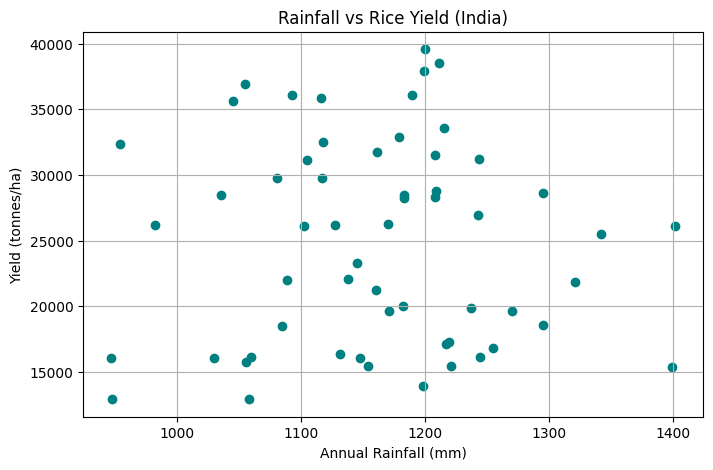

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for plotting
pandas_df = combined_df.toPandas()

plt.figure(figsize=(8,5))
plt.scatter(pandas_df["Annual_Rainfall_mm"], pandas_df["Yield_tonnes_per_ha"], color="teal")
plt.title("Rainfall vs Rice Yield (India)")
plt.xlabel("Annual Rainfall (mm)")
plt.ylabel("Yield (tonnes/ha)")
plt.grid(True)
plt.show()


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Prepare for ML
assembler = VectorAssembler(inputCols=["Annual_Rainfall_mm"], outputCol="features")
ml_df = assembler.transform(combined_df).select("features", "Yield_tonnes_per_ha")

# Split data
train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="Yield_tonnes_per_ha")
model = lr.fit(train_df)

# Evaluate
results = model.evaluate(test_df)
print(f"R²: {results.r2:.3f}")
print(f"RMSE: {results.rootMeanSquaredError:.3f}")


R²: -0.323
RMSE: 7715.480


Rainfall_mm,Yield_tonnes_per_ha,prediction
1118.0,32509,25197.278948580784
1160.8,21272,25587.727846741247
1035.4,28508,24443.749065682317
1220.9,15498,26135.99837897125
1207.8,28303,26016.491823693163
1269.7,19613,26581.18310397664
1189.2,36077,25846.810760473894
1198.0,13959,25927.089973179784
1170.7,19623,25678.04196103538
1200.3,39568,25948.072040137005


Databricks visualization. Run in Databricks to view.

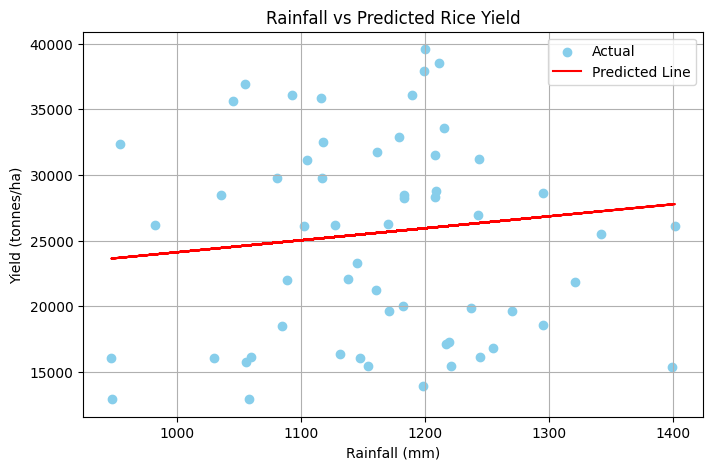

In [0]:
# Predict yield based on rainfall
predictions = model.transform(ml_df)

# Convert predictions to Pandas
pred_df = predictions.toPandas()

# Extract rainfall values from the "features" column
pred_df["Rainfall_mm"] = pred_df["features"].apply(lambda x: float(x[0]))

# Plot actual vs predicted yield
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(pred_df["Rainfall_mm"], pred_df["Yield_tonnes_per_ha"], label="Actual", color="skyblue")
plt.plot(pred_df["Rainfall_mm"], pred_df["prediction"], color="red", label="Predicted Line")
plt.title("Rainfall vs Predicted Rice Yield")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Yield (tonnes/ha)")
plt.legend()
plt.grid(True)



# ✅ Step 1 — Convert Pandas to Spark DataFrame for Dashboard visualization
spark_pred_df = spark.createDataFrame(pred_df[["Rainfall_mm", "Yield_tonnes_per_ha", "prediction"]])

# ✅ Step 2 — Display DataFrame (this enables the + Add Visualization option)
display(spark_pred_df)

In [0]:
combined_df.write.mode("overwrite").saveAsTable("workspace.default.rainfall_yield_combined")


In [0]:
# USE CASE 3 Simple Crop-Specific Climate Matching
# Load dataset directly from Databricks workspace.default schema
df = spark.table("workspace.default.crop_recommendation")

# Show first few rows to confirm data loaded
display(df.limit(5))

N,P,K,temperature,humidity,ph,rainfall,label
90,42,43,20.87974371,82.00274423,6.502985292000001,202.9355362,rice
85,58,41,21.77046169,80.31964408,7.038096361,226.6555374,rice
60,55,44,23.00445915,82.3207629,7.840207144,263.9642476,rice
74,35,40,26.49109635,80.15836264,6.980400905,242.8640342,rice
78,42,42,20.13017482,81.60487287,7.628472891,262.7173405,rice


In [0]:
# Print schema and columns
print("Columns:", df.columns)
df.printSchema()

# Drop missing and duplicate rows
df = df.dropna().dropDuplicates()

# Rename label to Crop for better clarity
from pyspark.sql.functions import col
df = df.withColumnRenamed("label", "Crop")

display(df.limit(5))

Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
root
 |-- N: integer (nullable = true)
 |-- P: integer (nullable = true)
 |-- K: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- label: string (nullable = true)



N,P,K,temperature,humidity,ph,rainfall,Crop
90,42,43,20.87974371,82.00274423,6.502985292000001,202.9355362,rice
85,58,41,21.77046169,80.31964408,7.038096361,226.6555374,rice
60,55,44,23.00445915,82.3207629,7.840207144,263.9642476,rice
74,35,40,26.49109635,80.15836264,6.980400905,242.8640342,rice
78,42,42,20.13017482,81.60487287,7.628472891,262.7173405,rice


In [0]:
# Select the crop for climate matching
selected_crop = "rice"

# Filter dataset for that crop
crop_df = df.filter(col("Crop") == selected_crop)

# Display filtered rows
display(crop_df.limit(5))

N,P,K,temperature,humidity,ph,rainfall,Crop
90,42,43,20.87974371,82.00274423,6.502985292000001,202.9355362,rice
85,58,41,21.77046169,80.31964408,7.038096361,226.6555374,rice
60,55,44,23.00445915,82.3207629,7.840207144,263.9642476,rice
74,35,40,26.49109635,80.15836264,6.980400905,242.8640342,rice
78,42,42,20.13017482,81.60487287,7.628472891,262.7173405,rice


In [0]:
from pyspark.sql import functions as F

# Compute min–max ranges of key climate variables
climate_range = crop_df.agg(
    F.min("temperature").alias("Min_Temp"),
    F.max("temperature").alias("Max_Temp"),
    F.min("humidity").alias("Min_Humidity"),
    F.max("humidity").alias("Max_Humidity"),
    F.min("rainfall").alias("Min_Rainfall"),
    F.max("rainfall").alias("Max_Rainfall"),
    F.min("ph").alias("Min_pH"),
    F.max("ph").alias("Max_pH")
)

display(climate_range)


Min_Temp,Max_Temp,Min_Humidity,Max_Humidity,Min_Rainfall,Max_Rainfall,Min_pH,Max_pH
20.0454142,26.92995077,80.12267476,84.96907151,182.5616319,298.5601175,5.005306977,7.868474653


In [0]:
# Collect range values into Python
limits = climate_range.collect()[0]

# Filter full dataset for matching conditions
matched_df = df.filter(
    (col("temperature") >= limits["Min_Temp"]) & (col("temperature") <= limits["Max_Temp"]) &
    (col("humidity") >= limits["Min_Humidity"]) & (col("humidity") <= limits["Max_Humidity"]) &
    (col("rainfall") >= limits["Min_Rainfall"]) & (col("rainfall") <= limits["Max_Rainfall"]) &
    (col("ph") >= limits["Min_pH"]) & (col("ph") <= limits["Max_pH"])
)

display(matched_df.limit(10))

N,P,K,temperature,humidity,ph,rainfall,Crop
90,42,43,20.87974371,82.00274423,6.502985292000001,202.9355362,rice
85,58,41,21.77046169,80.31964408,7.038096361,226.6555374,rice
60,55,44,23.00445915,82.3207629,7.840207144,263.9642476,rice
74,35,40,26.49109635,80.15836264,6.980400905,242.8640342,rice
78,42,42,20.13017482,81.60487287,7.628472891,262.7173405,rice
69,37,42,23.05804872,83.37011772,7.073453503,251.0549998,rice
69,55,38,22.70883798,82.63941394,5.70080568,271.3248604,rice
94,53,40,20.27774362,82.89408619,5.718627177999999,241.9741949,rice
89,54,38,24.51588066,83.53521629999999,6.685346424,230.4462359,rice
68,58,38,23.22397386,83.03322691,6.336253525,221.2091958,rice


temperature,rainfall,Crop
20.87974371,202.9355362,rice
21.77046169,226.6555374,rice
23.00445915,263.9642476,rice
26.49109635,242.8640342,rice
20.13017482,262.7173405,rice
23.05804872,251.0549998,rice
22.70883798,271.3248604,rice
20.27774362,241.9741949,rice
24.51588066,230.4462359,rice
23.22397386,221.2091958,rice


Databricks visualization. Run in Databricks to view.

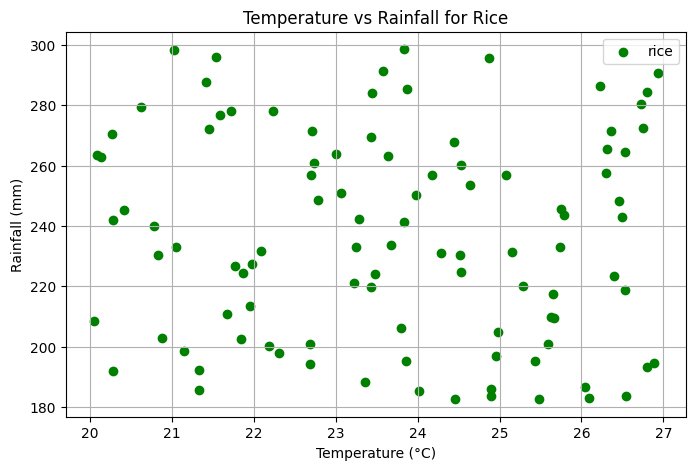

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas for plotting
pandas_df = df.toPandas()
crop_data = pandas_df[pandas_df["Crop"] == selected_crop]


plt.figure(figsize=(8,5))
plt.scatter(crop_data["temperature"], crop_data["rainfall"], color="green", label=selected_crop)
plt.title(f"Temperature vs Rainfall for {selected_crop.capitalize()}")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.legend()


# ✅ Step 1: Convert Pandas → Spark DataFrame (for dashboard visual option)
spark_crop_df = spark.createDataFrame(crop_data[["temperature", "rainfall", "Crop"]])

# ✅ Step 2: Display DataFrame (this enables + Add Visualization option)
display(spark_crop_df)



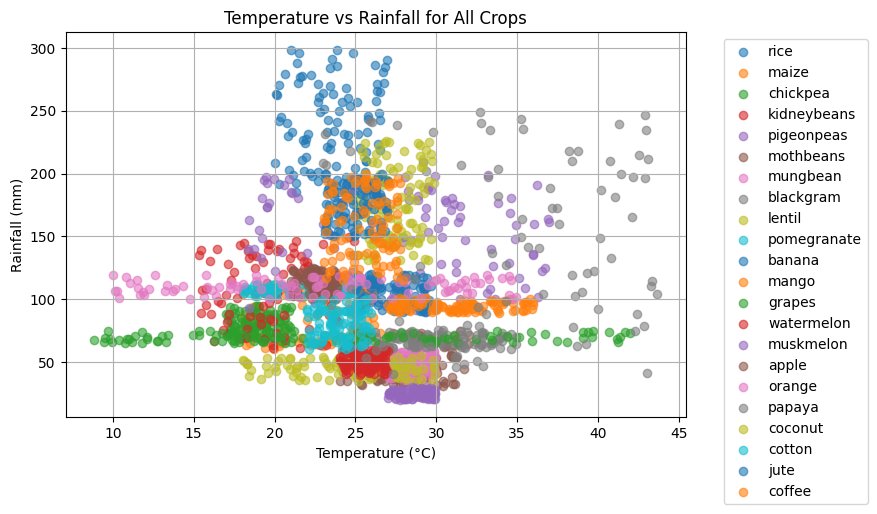

In [0]:
plt.figure(figsize=(8,5))
for crop in pandas_df["Crop"].unique():
    subset = pandas_df[pandas_df["Crop"] == crop]
    plt.scatter(subset["temperature"], subset["rainfall"], label=crop, alpha=0.6)

plt.title("Temperature vs Rainfall for All Crops")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rainfall (mm)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [0]:
matched_df.write.mode("overwrite").saveAsTable("workspace.default.crop_climate_match")
print("✅ Climate match results saved successfully to workspace.default.crop_climate_match")

✅ Climate match results saved successfully to workspace.default.crop_climate_match


In [0]:
# USE CASE 4 Timing of Key Events (GDD)
# Load the climate dataset from workspace.default
df = spark.table("workspace.default.daily_delhi_climate_test")

# Display sample data
display(df.limit(5))

date,meantemp,humidity,wind_speed,meanpressure
2017-01-01,15.91304347826087,85.8695652173913,2.743478260869565,59.0
2017-01-02,18.5,77.22222222222223,2.8944444444444444,1018.2777777777778
2017-01-03,17.11111111111111,81.88888888888889,4.016666666666667,1018.3333333333334
2017-01-04,18.7,70.05,4.545,1015.7
2017-01-05,18.38888888888889,74.94444444444444,3.3000000000000003,1014.3333333333334


In [0]:
# Print schema and columns
df.printSchema()
print("Columns:", df.columns)

# Drop missing or duplicate values
df = df.dropna().dropDuplicates()

# Convert date column to proper date type
from pyspark.sql.functions import col, to_date
df = df.withColumn("date", to_date(col("date")))

# Sort by date
df = df.orderBy("date")

display(df.limit(5))


root
 |-- date: date (nullable = true)
 |-- meantemp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- meanpressure: double (nullable = true)

Columns: ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']


date,meantemp,humidity,wind_speed,meanpressure
2017-01-01,15.91304347826087,85.8695652173913,2.743478260869565,59.0
2017-01-02,18.5,77.22222222222223,2.8944444444444444,1018.2777777777778
2017-01-03,17.11111111111111,81.88888888888889,4.016666666666667,1018.3333333333334
2017-01-04,18.7,70.05,4.545,1015.7
2017-01-05,18.38888888888889,74.94444444444444,3.3000000000000003,1014.3333333333334


In [0]:
from pyspark.sql import functions as F

# Base temperature (for rice)
T_base = 10  

# Calculate GDD
df = df.withColumn("GDD", (F.col("meantemp") - T_base))

# Replace negative GDD values with 0 (no growth below base temp)
df = df.withColumn("GDD", F.when(F.col("GDD") < 0, 0).otherwise(F.col("GDD")))

display(df.limit(5))

date,meantemp,humidity,wind_speed,meanpressure,GDD
2017-01-01,15.91304347826087,85.8695652173913,2.743478260869565,59.0,5.913043478260869
2017-01-02,18.5,77.22222222222223,2.8944444444444444,1018.2777777777778,8.5
2017-01-03,17.11111111111111,81.88888888888889,4.016666666666667,1018.3333333333334,7.111111111111111
2017-01-04,18.7,70.05,4.545,1015.7,8.7
2017-01-05,18.38888888888889,74.94444444444444,3.3000000000000003,1014.3333333333334,8.38888888888889


In [0]:
from pyspark.sql.window import Window

# Define window by date
windowSpec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, 0)

# Add cumulative GDD column
df = df.withColumn("Cumulative_GDD", F.sum("GDD").over(windowSpec))

display(df.limit(10))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning:

WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



date,meantemp,humidity,wind_speed,meanpressure,GDD,Cumulative_GDD
2017-01-01,15.91304347826087,85.8695652173913,2.743478260869565,59.0,5.913043478260869,5.913043478260869
2017-01-02,18.5,77.22222222222223,2.8944444444444444,1018.2777777777778,8.5,14.41304347826087
2017-01-03,17.11111111111111,81.88888888888889,4.016666666666667,1018.3333333333334,7.111111111111111,21.52415458937198
2017-01-04,18.7,70.05,4.545,1015.7,8.7,30.22415458937198
2017-01-05,18.38888888888889,74.94444444444444,3.3000000000000003,1014.3333333333334,8.38888888888889,38.61304347826087
2017-01-06,19.318181818181817,79.31818181818181,8.681818181818182,1011.7727272727273,9.318181818181817,47.93122529644269
2017-01-07,14.708333333333334,95.83333333333333,10.041666666666664,1011.375,4.708333333333334,52.639558629776026
2017-01-08,15.68421052631579,83.52631578947368,1.95,1015.55,5.684210526315789,58.323769156091814
2017-01-09,14.571428571428571,80.80952380952381,6.542857142857142,1015.952380952381,4.571428571428571,62.89519772752038
2017-01-10,12.11111111111111,71.94444444444444,9.361111111111109,1016.8888888888889,2.1111111111111107,65.0063088386315


In [0]:
df = df.withColumn(
    "Growth_Stage",
    F.when(F.col("Cumulative_GDD") < 100, "Germination")
     .when((F.col("Cumulative_GDD") >= 100) & (F.col("Cumulative_GDD") < 500), "Tillering")
     .when((F.col("Cumulative_GDD") >= 500) & (F.col("Cumulative_GDD") < 1100), "Flowering")
     .when((F.col("Cumulative_GDD") >= 1100) & (F.col("Cumulative_GDD") < 1600), "Grain Filling")
     .otherwise("Maturity")
)

display(df.limit(15))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning:

WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



date,meantemp,humidity,wind_speed,meanpressure,GDD,Cumulative_GDD,Growth_Stage
2017-01-01,15.91304347826087,85.8695652173913,2.743478260869565,59.0,5.913043478260869,5.913043478260869,Germination
2017-01-02,18.5,77.22222222222223,2.8944444444444444,1018.2777777777778,8.5,14.41304347826087,Germination
2017-01-03,17.11111111111111,81.88888888888889,4.016666666666667,1018.3333333333334,7.111111111111111,21.52415458937198,Germination
2017-01-04,18.7,70.05,4.545,1015.7,8.7,30.22415458937198,Germination
2017-01-05,18.38888888888889,74.94444444444444,3.3000000000000003,1014.3333333333334,8.38888888888889,38.61304347826087,Germination
2017-01-06,19.318181818181817,79.31818181818181,8.681818181818182,1011.7727272727273,9.318181818181817,47.93122529644269,Germination
2017-01-07,14.708333333333334,95.83333333333333,10.041666666666664,1011.375,4.708333333333334,52.639558629776026,Germination
2017-01-08,15.68421052631579,83.52631578947368,1.95,1015.55,5.684210526315789,58.323769156091814,Germination
2017-01-09,14.571428571428571,80.80952380952381,6.542857142857142,1015.952380952381,4.571428571428571,62.89519772752038,Germination
2017-01-10,12.11111111111111,71.94444444444444,9.361111111111109,1016.8888888888889,2.1111111111111107,65.0063088386315,Germination


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning:

WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



date,Cumulative_GDD
2017-01-01T00:00:00.000Z,5.913043478260869
2017-01-02T00:00:00.000Z,14.41304347826087
2017-01-03T00:00:00.000Z,21.52415458937198
2017-01-04T00:00:00.000Z,30.22415458937198
2017-01-05T00:00:00.000Z,38.61304347826087
2017-01-06T00:00:00.000Z,47.93122529644269
2017-01-07T00:00:00.000Z,52.639558629776026
2017-01-08T00:00:00.000Z,58.323769156091814
2017-01-09T00:00:00.000Z,62.89519772752038
2017-01-10T00:00:00.000Z,65.0063088386315


Databricks visualization. Run in Databricks to view.

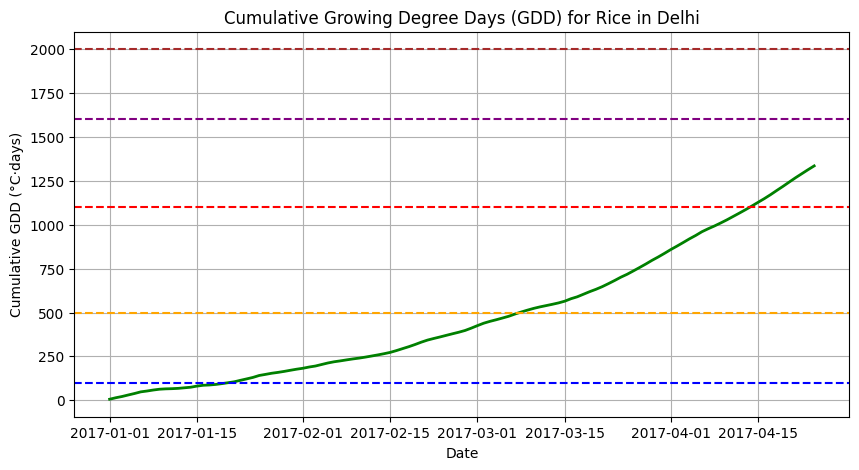

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
pdf = df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

# Plot cumulative GDD over time
plt.figure(figsize=(10,5))
plt.plot(pdf["date"], pdf["Cumulative_GDD"], color="green", linewidth=2)
plt.title("Cumulative Growing Degree Days (GDD) for Rice in Delhi")
plt.xlabel("Date")
plt.ylabel("Cumulative GDD (°C·days)")
plt.grid(True)

# Add threshold lines
plt.axhline(100, color="blue", linestyle="--", label="Germination (100)")
plt.axhline(500, color="orange", linestyle="--", label="Tillering (500)")
plt.axhline(1100, color="red", linestyle="--", label="Flowering (1100)")
plt.axhline(1600, color="purple", linestyle="--", label="Grain Filling (1600)")
plt.axhline(2000, color="brown", linestyle="--", label="Maturity (2000)")


# ✅ Create a DataFrame from your actual data to use in the dashboard
viz_gdd = spark.createDataFrame(pdf[['date', 'Cumulative_GDD']])

# ✅ Display it — this is where you’ll get the ➕ icon
display(viz_gdd)




In [0]:
from pyspark.sql.functions import max as spark_max

# Get final cumulative GDD
final_gdd = df.agg(spark_max("Cumulative_GDD")).collect()[0][0]

print(f"✅ Total accumulated GDD for rice in Delhi dataset = {final_gdd:.2f} °C·days")

print("""
🌾 Insights:
- Crop: Rice
- Base Temperature (Tbase): 10°C
- Key Events:
    • Germination ~100 GDD
    • Tillering ~500 GDD
    • Flowering ~1100 GDD
    • Grain Filling ~1600 GDD
    • Maturity ~2000 GDD
- This analysis helps estimate approximate timing for each growth stage,
  improving planting and harvesting schedules based on temperature trends.
""")


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning:

WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



✅ Total accumulated GDD for rice in Delhi dataset = 1335.29 °C·days

🌾 Insights:
- Crop: Rice
- Base Temperature (Tbase): 10°C
- Key Events:
    • Germination ~100 GDD
    • Tillering ~500 GDD
    • Flowering ~1100 GDD
    • Grain Filling ~1600 GDD
    • Maturity ~2000 GDD
- This analysis helps estimate approximate timing for each growth stage,
  improving planting and harvesting schedules based on temperature trends.



In [0]:
df.write.mode("overwrite").saveAsTable("workspace.default.delhi_gdd_results")
print("✅ GDD results saved as workspace.default.delhi_gdd_results")


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning:

WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



✅ GDD results saved as workspace.default.delhi_gdd_results


In [0]:
# USE CASE 5 Simple Soil Type Recommendation
# Load your dataset table
df = spark.table("workspace.default.data_core")

# Display first few rows
display(df.limit(5))

Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [0]:
# Show schema and column names
df.printSchema()

# Check total rows and missing values
print(f"Total rows: {df.count()}")
for col_name in df.columns:
    missing = df.filter(df[col_name].isNull()).count()
    print(f"{col_name}: {missing} missing")

# Drop null or duplicate records
df = df.dropna().dropDuplicates()

# Show cleaned dataset
display(df.limit(5))


root
 |-- Temparature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- Soil Type: string (nullable = true)
 |-- Crop Type: string (nullable = true)
 |-- Nitrogen: long (nullable = true)
 |-- Potassium: long (nullable = true)
 |-- Phosphorous: long (nullable = true)
 |-- Fertilizer Name: string (nullable = true)

Total rows: 8000
Temparature: 0 missing
Humidity: 0 missing
Moisture: 0 missing
Soil Type: 0 missing
Crop Type: 0 missing
Nitrogen: 0 missing
Potassium: 0 missing
Phosphorous: 0 missing
Fertilizer Name: 0 missing


Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [0]:
# Replace "Soil type" with the actual name from your dataset
df = df.withColumnRenamed("Soil type", "Soil_Type")


In [0]:
df = df.withColumnRenamed("soil_type", "Soil_Type")

In [0]:
df.select("Soil_Type").show(5)


+---------+
|Soil_Type|
+---------+
|    Sandy|
|    Loamy|
|    Black|
|      Red|
|   Clayey|
+---------+
only showing top 5 rows


In [0]:
df = spark.table("default.data_core")
display(df)


Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea
26.0,52.0,35.0,Sandy,Barley,12,10,13,17-17-17
25.0,50.0,64.0,Red,Cotton,9,0,10,20-20
33.0,64.0,50.0,Loamy,Wheat,41,0,0,Urea
30.0,60.0,42.0,Sandy,Millets,21,0,18,28-28
29.0,58.0,33.0,Black,Oil seeds,9,7,30,14-35-14


In [0]:
df = spark.table("default.data_core")
df.printSchema()

root
 |-- Temparature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- Soil Type: string (nullable = true)
 |-- Crop Type: string (nullable = true)
 |-- Nitrogen: long (nullable = true)
 |-- Potassium: long (nullable = true)
 |-- Phosphorous: long (nullable = true)
 |-- Fertilizer Name: string (nullable = true)



In [0]:
from pyspark.sql import SparkSession
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ✅ Step 1: Load from Databricks table
df = spark.table("default.data_core")
print("📦 Data loaded successfully from Databricks table!")

# ✅ Step 2: Convert to Pandas
pandas_df = df.toPandas()

# ✅ Step 3: Identify actual column name
print("🧩 Available columns:", pandas_df.columns.tolist())

# ✅ Step 4: Encode the correct column name
encoder = LabelEncoder()
# 👇 Replace 'Soil Type' below with the actual column name from the above print output
pandas_df['label'] = encoder.fit_transform(pandas_df['Soil Type'])  

# ✅ Step 5: Convert back to Spark DataFrame
encoded_df = spark.createDataFrame(pandas_df)

# ✅ Step 6: Display results
display(encoded_df.select("Soil Type", "label").distinct())

print("✅ Soil Type successfully encoded with no cache or path issues!")


📦 Data loaded successfully from Databricks table!
🧩 Available columns: ['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


Soil Type,label
Black,0
Loamy,2
Red,3
Clayey,1
Sandy,4


✅ Soil Type successfully encoded with no cache or path issues!


In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ✅ Step 1: Load dataset from Databricks table
df = spark.table("default.data_core")
print("📦 Data loaded successfully!")

# ✅ Step 2: Convert to Pandas (required for LabelEncoder)
pandas_df = df.toPandas()

# ✅ Step 3: Encode multiple text columns safely
encoder = LabelEncoder()
for col_name in ['Crop Type', 'Fertilizer Name']:
    if col_name in pandas_df.columns:
        pandas_df[col_name + '_encoded'] = encoder.fit_transform(pandas_df[col_name])
        print(f"✅ Encoded column: {col_name}")

# ✅ Step 4: Convert back to Spark DataFrame
encoded_df = spark.createDataFrame(pandas_df)

# ✅ Step 5: Display final encoded columns
display(encoded_df.select('Crop Type', 'Crop Type_encoded', 'Fertilizer Name', 'Fertilizer Name_encoded').distinct())

print("🎉 Encoding completed successfully without Spark ML cache errors!")


📦 Data loaded successfully!
✅ Encoded column: Crop Type
✅ Encoded column: Fertilizer Name


Crop Type,Crop Type_encoded,Fertilizer Name,Fertilizer Name_encoded
Ground Nuts,2,10-26-26,0
Tobacco,9,20-20,3
Cotton,1,28-28,4
Millets,4,28-28,4
Sugarcane,8,DAP,5
Pulses,7,Urea,6
Oil seeds,5,28-28,4
Paddy,6,Urea,6
Pulses,7,DAP,5
Wheat,10,14-35-14,1


🎉 Encoding completed successfully without Spark ML cache errors!


In [0]:
df.printSchema()


root
 |-- Temparature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- Soil Type: string (nullable = true)
 |-- Crop Type: string (nullable = true)
 |-- Nitrogen: long (nullable = true)
 |-- Potassium: long (nullable = true)
 |-- Phosphorous: long (nullable = true)
 |-- Fertilizer Name: string (nullable = true)



In [0]:
display(df.limit(5))


Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [0]:
target_col = "Soil Type"


In [0]:
from pyspark.ml.feature import VectorAssembler

# ✅ Step 1: Use the encoded dataframe (from your previous block)
df = encoded_df  # Ensure 'encoded_df' exists

# ✅ Step 2: List numeric columns
numeric_cols = [c for c, dtype in df.dtypes if dtype in ("int", "double")]

# ✅ Step 3: Add encoded columns (like 'Crop Type_encoded', 'Fertilizer Name_encoded')
encoded_cols = [c for c in df.columns if c.endswith("_encoded")]

# ✅ Combine all feature columns
feature_cols = numeric_cols + encoded_cols

# ✅ Step 4: Define your actual target column (change name based on your dataset)
target_col = "Soil Type"  # 👈 change this if your dataset uses a different name

# ✅ Step 5: Remove the target column from features if present
feature_cols = [c for c in feature_cols if c != target_col]

# ✅ Step 6: Assemble features into one vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ✅ Step 7: Create final dataset for ML
final_df = assembler.transform(df).select("features", target_col)

# ✅ Step 8: Preview
display(final_df.limit(5))
print("✅ Feature vector successfully created for ML model training!")


features,Soil Type
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""26.0"",""52.0"",""38.0"",""3.0"",""6.0""]}",Sandy
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""29.0"",""52.0"",""45.0"",""8.0"",""5.0""]}",Loamy
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""34.0"",""65.0"",""62.0"",""1.0"",""1.0""]}",Black
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""32.0"",""62.0"",""34.0"",""9.0"",""4.0""]}",Red
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""28.0"",""54.0"",""46.0"",""6.0"",""6.0""]}",Clayey


✅ Feature vector successfully created for ML model training!


In [0]:
final_df.printSchema()


root
 |-- features: vectorudt (nullable = true)
 |-- Soil Type: string (nullable = true)



In [0]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)
print("Training rows:", train_df.count())
print("Testing rows:", test_df.count())


Training rows: 6427
Testing rows: 1573


In [0]:
# ✅ Lightweight Decision Tree model (no Spark ML cache, fully compatible with Databricks Serverless)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Convert Spark DataFrame to Pandas
pdf = final_df.toPandas()

# Extract features and labels safely
# Each element in 'features' is a DenseVector, so we convert it to a flat list of columns
X = pd.DataFrame(pdf["features"].apply(lambda v: v.toArray()).tolist())
y = pdf["Soil Type"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree (lightweight, fast)
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("✅ Model trained successfully (No Spark ML cache used)")
print(f"🎯 Test Accuracy: {accuracy * 100:.2f}%")


✅ Model trained successfully (No Spark ML cache used)
🎯 Test Accuracy: 20.31%


In [0]:
# ✅ Correct evaluation for scikit-learn model (no Spark ML transform step)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# Step 1: Make predictions using sklearn model
y_pred = model.predict(X_test)

# Step 2: Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully (No Spark ML cache used)")
print(f"🎯 Test Accuracy: {accuracy * 100:.2f}%")

# Step 3: Show confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Convert predictions into a Pandas + Spark dataframe for Databricks visualization
predictions_pdf = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
predictions_df = spark.createDataFrame(predictions_pdf)
display(predictions_df)


✅ Model trained successfully (No Spark ML cache used)
🎯 Test Accuracy: 20.31%

Confusion Matrix:
[[ 14 309   2   8   0]
 [  8 297   5  18   0]
 [ 11 300   2   6   0]
 [ 10 283   3  12   0]
 [  6 297   1   8   0]]

Classification Report:
              precision    recall  f1-score   support

       Black       0.29      0.04      0.07       333
      Clayey       0.20      0.91      0.33       328
       Loamy       0.15      0.01      0.01       319
         Red       0.23      0.04      0.07       308
       Sandy       0.00      0.00      0.00       312

    accuracy                           0.20      1600
   macro avg       0.17      0.20      0.10      1600
weighted avg       0.18      0.20      0.10      1600



/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Actual,Predicted
Sandy,Clayey
Loamy,Clayey
Loamy,Clayey
Clayey,Clayey
Red,Clayey
Clayey,Clayey
Clayey,Clayey
Black,Clayey
Sandy,Clayey
Loamy,Clayey


Databricks visualization. Run in Databricks to view.

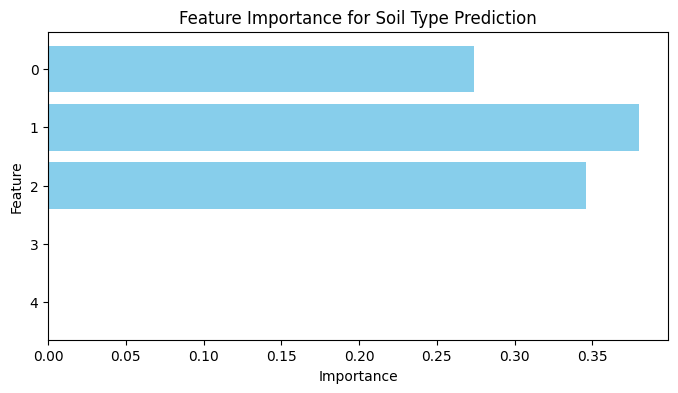

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Get feature importances from sklearn model
importances = model.feature_importances_

# Create a DataFrame with feature names and importance values
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# ✅ Plot
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Soil Type Prediction")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [0]:
# 🧹 Completely clear old model objects
for var in ['assembler', 'model', 'indexer', 'indexer_model']:
    try:
        del globals()[var]
    except:
        pass

print("✅ Cleared all cached model and assembler objects.")


✅ Cleared all cached model and assembler objects.


In [0]:
print("✅ Current DataFrame Columns:")
print(df.columns)


✅ Current DataFrame Columns:
['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name', 'Crop Type_encoded', 'Fertilizer Name_encoded']


In [0]:
df.printSchema()


root
 |-- Temparature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- Soil Type: string (nullable = true)
 |-- Crop Type: string (nullable = true)
 |-- Nitrogen: long (nullable = true)
 |-- Potassium: long (nullable = true)
 |-- Phosphorous: long (nullable = true)
 |-- Fertilizer Name: string (nullable = true)
 |-- Crop Type_encoded: long (nullable = true)
 |-- Fertilizer Name_encoded: long (nullable = true)



In [0]:
# Clean column names (trim spaces and fix typos)
for old_col in df.columns:
    new_col = old_col.strip().replace(" ", "_").replace("Temparature", "Temperature")
    df = df.withColumnRenamed(old_col, new_col)

# Verify cleaned names
df.printSchema()


root
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop_Type: string (nullable = true)
 |-- Nitrogen: long (nullable = true)
 |-- Potassium: long (nullable = true)
 |-- Phosphorous: long (nullable = true)
 |-- Fertilizer_Name: string (nullable = true)
 |-- Crop_Type_encoded: long (nullable = true)
 |-- Fertilizer_Name_encoded: long (nullable = true)



In [0]:
pdf = df.select("Temperature", "Humidity", "Moisture", "Nitrogen", "Potassium", "Phosphorous", "Soil_Type").toPandas()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pdf["label"] = le.fit_transform(pdf["Soil_Type"])

from sklearn.model_selection import train_test_split
X = pdf[["Temperature", "Humidity", "Moisture", "Nitrogen", "Potassium", "Phosphorous"]]
y = pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully (Local sklearn mode)")
print(f"🎯 Accuracy: {accuracy * 100:.2f}%")


✅ Model trained successfully (Local sklearn mode)
🎯 Accuracy: 20.69%


In [0]:
print(pdf.columns.tolist())


['Temperature', 'Humidity', 'Moisture', 'Soil_Type', 'Crop_Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer_Name', 'Crop_Type_encoded', 'Fertilizer_Name_encoded']


In [0]:
pdf["label"] = le.fit_transform(pdf["Soil_Type"])


In [0]:
# Convert to Pandas
pdf = df.toPandas()

# Check column names
print(pdf.columns.tolist())  # helps confirm column names

# Encode the correct soil column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pdf["label"] = le.fit_transform(pdf["Soil_Type"])  # use the correct name here

# Split features and label
X = pdf[["Temperature", "Humidity", "Moisture", "Nitrogen", "Potassium", "Phosphorous"]]
y = pdf["label"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("✅ Model trained successfully (Local sklearn mode)")
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


['Temperature', 'Humidity', 'Moisture', 'Soil_Type', 'Crop_Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer_Name', 'Crop_Type_encoded', 'Fertilizer_Name_encoded']
✅ Model trained successfully (Local sklearn mode)
🎯 Accuracy: 20.69%

Classification Report:
               precision    recall  f1-score   support

       Black       0.26      0.05      0.08       333
      Clayey       0.21      0.95      0.34       328
       Loamy       0.25      0.01      0.01       319
         Red       0.00      0.00      0.00       308
       Sandy       0.00      0.00      0.00       312

    accuracy                           0.21      1600
   macro avg       0.14      0.20      0.09      1600
weighted avg       0.15      0.21      0.09      1600



/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

